In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data = pd.read_csv('data_sml2010.csv')

In [4]:
target = np.load('target_sml2010.npy')

In [5]:
cols = np.load('cols_sml2010.npy')

In [6]:
cols

array(['4:Temperature_Habitacion_Sensor', '5:Weather_Temperature',
       '6:CO2_Comedor_Sensor', '7:CO2_Habitacion_Sensor',
       '8:Humedad_Comedor_Sensor', '9:Humedad_Habitacion_Sensor',
       '10:Lighting_Comedor_Sensor', '11:Lighting_Habitacion_Sensor',
       '12:Precipitacion', '13:Meteo_Exterior_Crepusculo',
       '14:Meteo_Exterior_Viento', '15:Meteo_Exterior_Sol_Oest',
       '16:Meteo_Exterior_Sol_Est', '17:Meteo_Exterior_Sol_Sud',
       '18:Meteo_Exterior_Piranometro', '19:Exterior_Entalpic_1',
       '20:Exterior_Entalpic_2', '21:Exterior_Entalpic_turbo',
       '22:Temperature_Exterior_Sensor'], dtype='<U31')

In [7]:
target

array('3:Temperature_Comedor_Sensor', dtype='<U28')

In [8]:
depth = 32

In [24]:
X = np.zeros((len(data), depth, len(cols)))
for i, name in enumerate(cols):
    for j in range(depth):
        X[:, j, i] = data[name].shift(depth - j - 1).bfill()

In [25]:
y = data[target].shift(-1).ffill().values

In [26]:
train_length = int(0.8*len(data))

In [27]:
X_train = X[:train_length]
X_test = X[train_length:]

y_train = y[:train_length]
y_test = y[train_length:]

In [28]:
X_train_min = X_train.min(axis=0)
X_train_max = X_train.max(axis=0)

In [29]:
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

In [56]:
y_train_min = y_train.min(axis=0)
y_train_max = y_train.max(axis=0)

In [57]:
y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

In [58]:
X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_test_t = torch.Tensor(y_test)

In [59]:
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)

In [110]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class TCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.first_layer(x)
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
        x = x[..., -1]
        out = self.output_transform(x)
        return out.squeeze(1)

In [170]:
model = TCN(X_train_t.shape[2], 5).cuda()

In [171]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [172]:
sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.9)

In [173]:
loss = nn.MSELoss()

In [174]:
early_stopping_rounds=10

In [175]:
vl = 99999
counter = 0
for e in range(300):
    train_loss = 0
    val_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        opt.zero_grad()
        
        output = model(batch_x)
        
        l = loss(output, batch_y)
        
        l.backward()
        
        opt.step()
        
        train_loss += l.item()
    
    sc.step()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
            output = model(batch_x)
            
            l = loss(output, batch_y)
            
            val_loss += l.item()
            
    if vl > val_loss:
        vl = val_loss
        torch.save(model.state_dict(), 'tcn_sml2010.pt')
        counter = 0
    
    else:
        counter += 1
        
    if counter >= early_stopping_rounds:
        break
        
    print('Iter: ', e, 'train_loss: ', train_loss, 'val_loss: ', val_loss)

Iter:  0 train_loss:  3.6677076993510127 val_loss:  0.2702104503987357
Iter:  1 train_loss:  0.8652645188849419 val_loss:  0.16882774129044265
Iter:  2 train_loss:  0.6057707113213837 val_loss:  0.09556646912824363
Iter:  3 train_loss:  0.5321923864539713 val_loss:  0.09767943614860997
Iter:  4 train_loss:  0.45665621757507324 val_loss:  0.08927835107897408
Iter:  5 train_loss:  0.41547248559072614 val_loss:  0.09956276218872517
Iter:  6 train_loss:  0.38602449279278517 val_loss:  0.08957377122715116
Iter:  7 train_loss:  0.36718813504558057 val_loss:  0.08967631429550238
Iter:  8 train_loss:  0.3377094909083098 val_loss:  0.09639261174015701
Iter:  9 train_loss:  0.3196712426142767 val_loss:  0.09764443861786276
Iter:  10 train_loss:  0.2831051354878582 val_loss:  0.09224876743974164
Iter:  11 train_loss:  0.27032882341882214 val_loss:  0.1004785541590536
Iter:  12 train_loss:  0.2392322116647847 val_loss:  0.09764040354639292
Iter:  13 train_loss:  0.24637340020854026 val_loss:  0.10

In [176]:
model.load_state_dict(torch.load('tcn_sml2010.pt'))

<All keys matched successfully>

In [177]:
preds = []
true = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        output = model(batch_x)
        
        true.append(batch_y.detach().cpu().numpy())
        preds.append(output.detach().cpu().numpy())

true = np.concatenate(true)
preds = np.concatenate(preds)

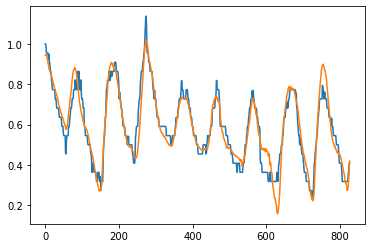

In [178]:
plt.plot(true)
plt.plot(preds)

In [179]:
importance_calculation_steps = 20
regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [180]:
from tqdm import tqdm_notebook

In [181]:
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

print("Calculating Importance:")
importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


([<matplotlib.axis.YTick at 0x7f89946a6ef0>,
 [Text(0, 0, '4:Temperature_Habitacion_Sensor'),
  Text(0, 1, '5:Weather_Temperature'),
  Text(0, 2, '6:CO2_Comedor_Sensor'),
  Text(0, 3, '7:CO2_Habitacion_Sensor'),
  Text(0, 4, '8:Humedad_Comedor_Sensor'),
  Text(0, 5, '9:Humedad_Habitacion_Sensor'),
  Text(0, 6, '10:Lighting_Comedor_Sensor'),
  Text(0, 7, '11:Lighting_Habitacion_Sensor'),
  Text(0, 8, '12:Precipitacion'),
  Text(0, 9, '13:Meteo_Exterior_Crepusculo'),
  Text(0, 10, '14:Meteo_Exterior_Viento'),
  Text(0, 11, '15:Meteo_Exterior_Sol_Oest'),
  Text(0, 12, '16:Meteo_Exterior_Sol_Est'),
  Text(0, 13, '17:Meteo_Exterior_Sol_Sud'),
  Text(0, 14, '18:Meteo_Exterior_Piranometro'),
  Text(0, 15, '19:Exterior_Entalpic_1'),
  Text(0, 16, '20:Exterior_Entalpic_2'),
  Text(0, 17, '21:Exterior_Entalpic_turbo'),
  Text(0, 18, '22:Temperature_Exterior_Sensor')])

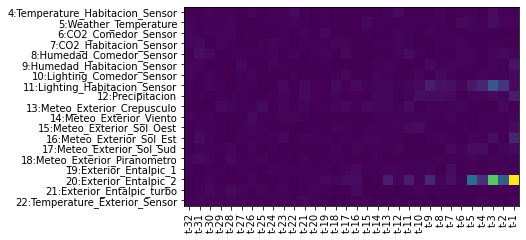

In [187]:
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(len(cols)), cols)

In [194]:
model = TCN(X_train_t.shape[2], 5).cuda()

In [195]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.9)

In [196]:
vl = 99999
counter = 0
for e in range(300):
    train_loss = 0
    val_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        opt.zero_grad()
        
        output = model(batch_x)
        
        l = loss(output, batch_y)
        
        l.backward()
        
        opt.step()
        
        train_loss += l.item()
    
    sc.step()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
            output = model(batch_x)
            
            l = loss(output, batch_y)
            
            val_loss += l.item()
            
    if vl > val_loss:
        vl = val_loss
        torch.save(model.state_dict(), 'tcn_sml2010.pt')
        counter = 0
    
    else:
        counter += 1
        
    if counter >= early_stopping_rounds:
        break
        
    print('Iter: ', e, 'train_loss: ', train_loss, 'val_loss: ', val_loss)

Iter:  0 train_loss:  5.312469212338328 val_loss:  0.2787647537770681
Iter:  1 train_loss:  1.0534939095377922 val_loss:  0.14921264827717096
Iter:  2 train_loss:  0.8084847454447299 val_loss:  0.13581739144865423
Iter:  3 train_loss:  0.7114624115638435 val_loss:  0.11567398166516796
Iter:  4 train_loss:  0.6211315779946744 val_loss:  0.11296734033385292
Iter:  5 train_loss:  0.5337702913675457 val_loss:  0.13370080140884966
Iter:  6 train_loss:  0.49049250420648605 val_loss:  0.13697045220760629
Iter:  7 train_loss:  0.46646058571059257 val_loss:  0.15345914871431887
Iter:  8 train_loss:  0.4238563517574221 val_loss:  0.12862760323332623
Iter:  9 train_loss:  0.3930116128176451 val_loss:  0.13229931180831045
Iter:  10 train_loss:  0.3710899919969961 val_loss:  0.13037703427835368
Iter:  11 train_loss:  0.3567686347523704 val_loss:  0.13588185430853628
Iter:  12 train_loss:  0.3204324805410579 val_loss:  0.1503045610152185
Iter:  13 train_loss:  0.30633806355763227 val_loss:  0.147012

In [197]:
model.load_state_dict(torch.load('tcn_sml2010.pt'))

<All keys matched successfully>

In [198]:
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

print("Calculating Importance:")
importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


([<matplotlib.axis.YTick at 0x7f8994526ef0>,
 [Text(0, 0, '4:Temperature_Habitacion_Sensor'),
  Text(0, 1, '5:Weather_Temperature'),
  Text(0, 2, '6:CO2_Comedor_Sensor'),
  Text(0, 3, '7:CO2_Habitacion_Sensor'),
  Text(0, 4, '8:Humedad_Comedor_Sensor'),
  Text(0, 5, '9:Humedad_Habitacion_Sensor'),
  Text(0, 6, '10:Lighting_Comedor_Sensor'),
  Text(0, 7, '11:Lighting_Habitacion_Sensor'),
  Text(0, 8, '12:Precipitacion'),
  Text(0, 9, '13:Meteo_Exterior_Crepusculo'),
  Text(0, 10, '14:Meteo_Exterior_Viento'),
  Text(0, 11, '15:Meteo_Exterior_Sol_Oest'),
  Text(0, 12, '16:Meteo_Exterior_Sol_Est'),
  Text(0, 13, '17:Meteo_Exterior_Sol_Sud'),
  Text(0, 14, '18:Meteo_Exterior_Piranometro'),
  Text(0, 15, '19:Exterior_Entalpic_1'),
  Text(0, 16, '20:Exterior_Entalpic_2'),
  Text(0, 17, '21:Exterior_Entalpic_turbo'),
  Text(0, 18, '22:Temperature_Exterior_Sensor')])

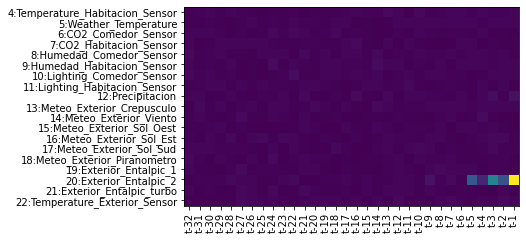

In [199]:
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(len(cols)), cols)

In [205]:
model = TCN(X_train_t.shape[2], 5).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.9)

In [206]:
vl = 99999
counter = 0
for e in range(300):
    train_loss = 0
    val_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        opt.zero_grad()
        
        output = model(batch_x)
        
        l = loss(output, batch_y)
        
        l.backward()
        
        opt.step()
        
        train_loss += l.item()
    
    sc.step()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            
            output = model(batch_x)
            
            l = loss(output, batch_y)
            
            val_loss += l.item()
            
    if vl > val_loss:
        vl = val_loss
        torch.save(model.state_dict(), 'tcn_sml2010.pt')
        counter = 0
    
    else:
        counter += 1
        
    if counter >= early_stopping_rounds:
        break
        
    print('Iter: ', e, 'train_loss: ', train_loss, 'val_loss: ', val_loss)

Iter:  0 train_loss:  3.7956792316399515 val_loss:  0.19259475846774876
Iter:  1 train_loss:  0.9967760341241956 val_loss:  0.17045606771716848
Iter:  2 train_loss:  0.7509106320794672 val_loss:  0.14650353247998282
Iter:  3 train_loss:  0.6188930885400623 val_loss:  0.0894757977075642
Iter:  4 train_loss:  0.4988807636545971 val_loss:  0.08721589887863956
Iter:  5 train_loss:  0.4710665063466877 val_loss:  0.09285415866179392
Iter:  6 train_loss:  0.4129877125378698 val_loss:  0.10210963239660487
Iter:  7 train_loss:  0.3523692318703979 val_loss:  0.10249158795340918
Iter:  8 train_loss:  0.34991128265392035 val_loss:  0.13294661784311756
Iter:  9 train_loss:  0.30859089113073424 val_loss:  0.1259322528494522
Iter:  10 train_loss:  0.3005489711649716 val_loss:  0.1262159819016233
Iter:  11 train_loss:  0.30092980089830235 val_loss:  0.12266218790318817
Iter:  12 train_loss:  0.230808834428899 val_loss:  0.1363159475440625
Iter:  13 train_loss:  0.21297500346554443 val_loss:  0.1155565

In [207]:
model.load_state_dict(torch.load('tcn_sml2010.pt'))

<All keys matched successfully>

In [208]:
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

model.eval()

print("Calculating Importance:")
importance_map = []
for batch_x, batch_y in tqdm_notebook(test_loader):
    batch_x = batch_x.cuda()
    #batch_y = batch_y.cuda()
    bx = batch_x
    y = model(batch_x)
    mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
    opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
    for e in range(importance_calculation_steps):
        opt.zero_grad()
        model.zero_grad()
        model.eval()
        y = y.detach()
        M = torch.sigmoid(mask)
        x_hat = bx*M
        y_hat = model(x_hat)
        l = mse_loss(y_hat, y)
        l += regularizer_coeff1*torch.sum(torch.abs(M))
        ones = torch.zeros_like(bx)
        ones[M>0.5] = 1
        l += 0.5*bce_loss(M, ones)
        l.backward()
        opt.step()
    M = torch.sigmoid(mask)
    #ms = ms.detach().cpu().numpy()
    thresholds = {}
    with torch.no_grad():
        for t in np.linspace(M.min().item(), M.max().item(), 100):
            M_clone = M.clone()
            M_clone[M_clone>t] = 1
            M_clone[M_clone<=t] = 0
            x_hat = bx*M_clone
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
            thresholds[l.item()] = t
    t = thresholds[min(thresholds.keys())]
    M = M.detach().cpu().numpy()
    M[M>t] = 1
    M[M<=t] = 0
    importance_map.append(np.abs(M))

importance_map = np.concatenate(importance_map)
importance_map = np.mean(importance_map, axis=0)

Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


([<matplotlib.axis.YTick at 0x7f8995997668>,
 [Text(0, 0, '4:Temperature_Habitacion_Sensor'),
  Text(0, 1, '5:Weather_Temperature'),
  Text(0, 2, '6:CO2_Comedor_Sensor'),
  Text(0, 3, '7:CO2_Habitacion_Sensor'),
  Text(0, 4, '8:Humedad_Comedor_Sensor'),
  Text(0, 5, '9:Humedad_Habitacion_Sensor'),
  Text(0, 6, '10:Lighting_Comedor_Sensor'),
  Text(0, 7, '11:Lighting_Habitacion_Sensor'),
  Text(0, 8, '12:Precipitacion'),
  Text(0, 9, '13:Meteo_Exterior_Crepusculo'),
  Text(0, 10, '14:Meteo_Exterior_Viento'),
  Text(0, 11, '15:Meteo_Exterior_Sol_Oest'),
  Text(0, 12, '16:Meteo_Exterior_Sol_Est'),
  Text(0, 13, '17:Meteo_Exterior_Sol_Sud'),
  Text(0, 14, '18:Meteo_Exterior_Piranometro'),
  Text(0, 15, '19:Exterior_Entalpic_1'),
  Text(0, 16, '20:Exterior_Entalpic_2'),
  Text(0, 17, '21:Exterior_Entalpic_turbo'),
  Text(0, 18, '22:Temperature_Exterior_Sensor')])

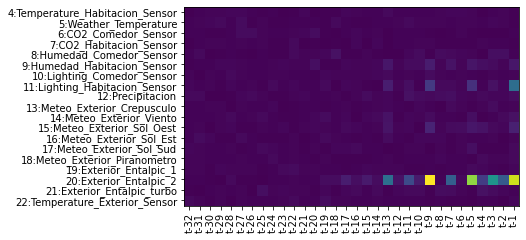

In [209]:
plt.imshow(importance_map.T)
plt.xticks(np.arange(depth), ["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
plt.yticks(np.arange(len(cols)), cols)